In [5]:
import pandas as pd
from pathlib import Path

csvpath= "Resources/Airbnb_cleaned.csv"

df= pd.read_csv(csvpath)

df = df.drop(columns=['Unnamed: 0'])

# Airbnb Map Section

In [6]:
# Listing count by NYC neighborhood dataframe
listing_count = df.groupby('neighbourhood')['id'].count().reset_index(name='number of listings')
listing_count.rename(columns={'neighbourhood': 'neighborhood'}, inplace=True)
listing_count

,neighborhood,number of listings
0,Allerton,94
1,Arden Heights,9
2,Arrochar,50
3,Arverne,221
4,Astoria,1831
...,...,...
219,Windsor Terrace,322
220,Woodhaven,189
221,Woodlawn,29
222,Woodrow,3


In [7]:
# NYC neighborhood stats CSV (/Resources)
avg_df = df.groupby(['neighbourhood group', 'neighbourhood'])[['price', 'service fee', 'review rate number']].mean().reset_index()
avg_df.rename(columns={'neighbourhood group': 'borough', 'neighbourhood': 'neighborhood'}, inplace=True) 
avg_df['price'] = avg_df['price'].astype('int64')
avg_df['service fee'] = avg_df['service fee'].astype('int64')
avg_df['review rate number'] = avg_df['review rate number'].round(2)
merged_avg_df = pd.merge(avg_df, listing_count, on='neighborhood', how='inner')
merged_avg_df.to_csv('Resources/neighborhood_stats.csv', index=False)
merged_avg_df

,borough,neighborhood,price,service fee,review rate number,number of listings
0,Bronx,Allerton,648,129,3.30,94
1,Bronx,Baychester,524,104,3.52,29
2,Bronx,Belmont,662,132,3.27,44
3,Bronx,Bronxdale,574,114,3.23,47
4,Bronx,Castle Hill,480,96,2.81,16
...,...,...,...,...,...,...
219,Staten Island,Tottenville,657,131,2.38,13
220,Staten Island,West Brighton,635,127,2.95,57
221,Staten Island,Westerleigh,477,95,3.60,5
222,Staten Island,Willowbrook,638,127,2.00,3


In [8]:
from pymongo import MongoClient

# Data cleaning and transformation

df.columns = [col.strip().replace(" ", "_").lower() for col in df.columns]  

df.fillna(0, inplace=True)

df['name'] = df['name'].str.title()

# Connect to MongoDB and insert the data
client = MongoClient("mongodb://localhost:27017/")  
db = client["airbnb_db"] 
collection = db["listings"]  

# Convert the DataFrame to a dictionary and insert into MongoDB
data_dict = df.to_dict(orient='records')  
collection.insert_many(data_dict)  

print(f"{len(data_dict)} records inserted into MongoDB.")  

100530 records inserted into MongoDB.


In [9]:
!! pip install seaborn

['Requirement already satisfied: seaborn in /opt/anaconda3/envs/mydev/lib/python3.12/site-packages (0.13.2)',
 'Requirement already satisfied: numpy!=1.24.0,>=1.20 in /opt/anaconda3/envs/mydev/lib/python3.12/site-packages (from seaborn) (1.26.4)',
 'Requirement already satisfied: pandas>=1.2 in /opt/anaconda3/envs/mydev/lib/python3.12/site-packages (from seaborn) (2.2.2)',
 'Requirement already satisfied: matplotlib!=3.6.1,>=3.4 in /opt/anaconda3/envs/mydev/lib/python3.12/site-packages (from seaborn) (3.8.4)',
 'Requirement already satisfied: contourpy>=1.0.1 in /opt/anaconda3/envs/mydev/lib/python3.12/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.2.0)',
 'Requirement already satisfied: cycler>=0.10 in /opt/anaconda3/envs/mydev/lib/python3.12/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (0.11.0)',
 'Requirement already satisfied: fonttools>=4.22.0 in /opt/anaconda3/envs/mydev/lib/python3.12/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (4.51.0)',
 'Requireme

In [10]:
#Correlation between reviews and ratings (using Seaborn)

import seaborn as sns
import matplotlib.pyplot as plt


# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the scatterplot or regression plot
plt.figure(figsize=(10, 6))
sns.regplot(x='number of reviews', y='review rate number', data=df, scatter_kws={'s': 20}, line_kws={'color': 'red'})

# Customize plot
plt.title('Correlation between Number of Reviews and Ratings', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Rating (1 to 5)', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

# Calculate correlation coefficient
correlation_reviews_ratings = df[['number of reviews', 'review rate number']].corr().iloc[0, 1]
print(f"Correlation between number of reviews and ratings: {correlation_reviews_ratings}")

KeyError: 'number of reviews'

<Figure size 1000x600 with 0 Axes>

C:\Users\shiza\AppData\Local\Temp\ipykernel_7596\1149085036.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review rate number'] = df['review rate number'].round(0).clip(upper=5)  # Round and clip the values to ensure they are between 1 and 5
C:\Users\shiza\AppData\Local\Temp\ipykernel_7596\1149085036.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price_Range'] = pd.cut(df['price'], bins=bins, labels=labels, right=False)
C:\Users\shiza\AppData\Local\Temp\ipykernel_7596\1149085036.py:15: Fu

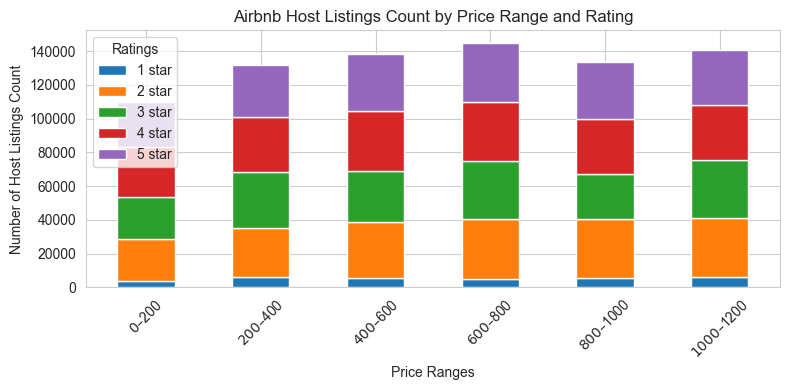

In [14]:
#Price Range vs Rating 

import numpy as np

# Remove ratings with value 0 and ensure ratings are between 1 and 5
df = df[df['review rate number'] > 0]  # Remove 0 ratings
df['review rate number'] = df['review rate number'].round(0).clip(upper=5)  # Round and clip the values to ensure they are between 1 and 5

# Define price ranges up to $1200
bins = [0, 200, 400, 600, 800, 1000, 1200]  # Price range bins
labels = ['$0–$200', '$200–$400', '$400–$600', '$600–$800', '$800–$1000', '$1000–$1200']

# Create a new column for price ranges
df['Price_Range'] = pd.cut(df['price'], bins=bins, labels=labels, right=False)

# Group by price range and review rate number, then sum the 'calculated host listings count'
grouped = df.groupby(['Price_Range', 'review rate number'])['calculated host listings count'].sum().unstack(fill_value=0)

# Ensure columns for ratings from 1 to 5 exist in the grouped data
grouped = grouped.reindex(columns=[1, 2, 3, 4, 5], fill_value=0)

# Extract price ranges and ratings data
price_ranges = grouped.index
data = grouped.values

# Set up the stacked bar chart
bar_width = 0.5
indices = np.arange(len(price_ranges))

# Stacking the bars
fig, ax = plt.subplots(figsize=(8, 4))

bottom = np.zeros(len(price_ranges))  # To stack bars on top of each other

# Plot each rating level (1 to 5 stars)
for i in range(data.shape[1]):
    ax.bar(indices, data[:, i], bar_width, bottom=bottom, label=f'{i+1} star')
    bottom += data[:, i]  # Update the bottom for the next bar segment

# Customizing the chart
ax.set_xlabel('Price Ranges')
ax.set_ylabel('Number of Host Listings Count')
ax.set_title('Airbnb Host Listings Count by Price Range and Rating')
ax.set_xticks(indices)
ax.set_xticklabels(price_ranges, rotation=45)
ax.legend(title="Ratings")

# Show the plot
plt.tight_layout()
plt.show()